# UE M2 Master MAS-MSS et CMI ISI --- Défi IA

# Projet 1: Classification d'images avec des réseaux de neurones profonds
<a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 150px; display: inline" alt="Python"/></a> & <a href="https://pytorch.org/">
    <img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.png" style="max-width: 200px; transform: scale(0.1);" alt="PyTorch"/>
</a>



**Résumé**: Dans ce projet, vous allez devoir implémenter des réseaux de neurones en `PyTorch` pour classifier des images couleurs de taille $3\times 128\times 128$ en $2$ classes (présence ou absence d'une éolienne dans des images satellites).

Nous vous fournissons un ensemble de données d'apprentissage de $32000$ images qui sont labélisées (c'est à dire que l'on vous fourni la classe de chaque image: présence ou abscence d'éoliennes), ainsi qu'un jeu de données de `validation` pour vérifier que votre modèle généralise bien sur des données qu'il n'a jamais vu.

**Évaluation**: Pour être évalués, votre réseau de neurone sera utilisé pour classifier $5000$ nouvelles images d'éolienne **auxquelles vous n'avez pas accès** (comme dans la vrai vie où l'on entraîne un modèle sur des données et l'on l'utilise sur de nouvelles données jamais vues avant). *À vous donc de vous assurez que votre modèle généralise bien*, en particulier grâce aux moyens vu au CM3. Veillez à vous assurer que le script à la fin de ce notebook fonctionne bien sur dossier `evaluation_finale`. (evaluation_finale contient 5000 images mais ce ne sont pas celles sur lesquelles vous serez réellement évalués).

Vous pouvez télécharger les données liées à ce projet dans les liens suivants :

1) Petit jeu de données (Small) :

https://filesender.renater.fr/?s=download&token=b378add0-833b-4194-8880-07a259b29cc1

2) Jeu de données complet :

https://filesender.renater.fr/?s=download&token=caf645fb-2193-4fc9-9b70-1d26053eb05f


Les attendus du projet sont :

- un court compte-rendu qui présente le meilleur modèle que vous avez obtenu, les idées qui vous ont amené à le concevoir, et sa validation à l'aide des données d'apprentissage,

- un fichier .csv qui contient les prédictions des classes pour les images de l'ensemble test à partir duquel un taux de bonne classification sera calculé en fin de projet (voir code à la fin du notebook).

Dans ce travail, vous pouvez créer vos propres architectures de réseaux de neurones, mais également utiliser des modèles pré-entraînés sur d'autres bases de données et les adapter à la problématique de classification d'images de ce projet. En PyTorch, vous pouvez utiliser des modèles pré-entraînés à partir de la bibliothèque torchvision.models, tels que ResNet, VGG, DenseNet, ou encore EfficientNet, et les ajuster (fine-tuning) à vos propres données. Un tutoriel sur l'apprentissage par transfert (qui ne sera abbordé que dans la deuxième partie du cours) en PyTorch est disponible ici :

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## 1 Prise en main des données

On donne ci-dessous un exemple code qui permet de lire une image de la base d'apprentissage pour chaque classe.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy, random
from collections import Counter

# Pytorch
import torch
from torchvision import datasets, transforms #transformation des données
from torch.utils.data import DataLoader #Pour ne pas charger toutes les données en mémoire d'un coup
import torch.nn #Module neural networks
import torch.optim #Module optimizers
from tqdm.notebook import tqdm #Pour faire une barre de progression pendant l'entrainement

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

In [ ]:
'''# check whether we use google colab or run locally
try:
  import google.colab
  using_colab = True
except:
  using_colab = False


if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # Chemin d'accès aux données dans Google Drive
    data_dir = '/content/drive/MyDrive/MSS/Projet_1_Defi_IA/Data_Small'
else:
    # Chemin d'accès aux données en local
    data_dir = './Data_Projet_1_Defi_IA'
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check whether we use google colab or run locally
try:
  import google.colab
  using_colab = True
except:
  using_colab = False


if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # Chemin d'accès aux données dans Google Drive
    data_dir = '/content/drive/MyDrive/MSS/Projet_1_Defi_IA/Data_Projet_1_Defi_IA'
else:
    # Chemin d'accès aux données en local
    data_dir = './Data_Projet_1_Defi_IA'

Mounted at /content/drive


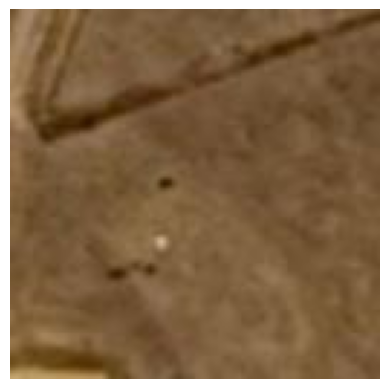

In [ ]:
# Chargement de l'image avec PIL
img_path = data_dir + '/train/target/S5163922366.jpg'
img = Image.open(img_path)

# Afficher l'image
plt.imshow(img)
plt.axis('off')  # Masquer les axes
plt.show()

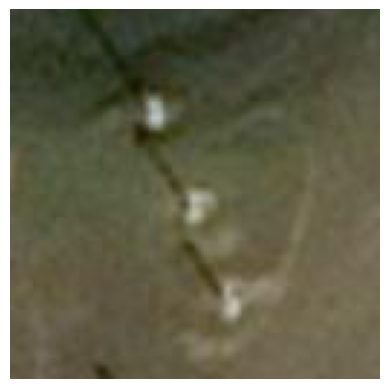

Taille de l'image (other):  torch.Size([3, 128, 128])


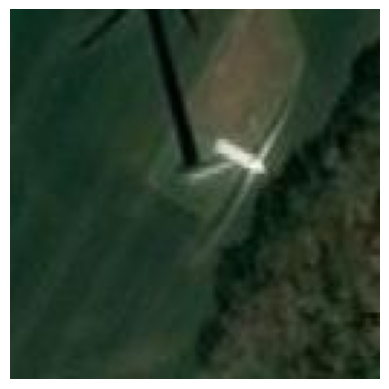

Premier canal de l'image (tensor): tensor([[0.2549, 0.2549, 0.2431,  ..., 0.2431, 0.2588, 0.2745],
        [0.2353, 0.2392, 0.2275,  ..., 0.2588, 0.2667, 0.2745],
        [0.2157, 0.2196, 0.2118,  ..., 0.2863, 0.2902, 0.2863],
        ...,
        [0.3608, 0.3647, 0.3686,  ..., 0.4588, 0.4627, 0.4667],
        [0.3804, 0.3804, 0.3765,  ..., 0.4510, 0.4549, 0.4588],
        [0.4039, 0.3961, 0.3843,  ..., 0.4392, 0.4431, 0.4431]])


In [ ]:
# Définir la transformation ToTensor
to_tensor = transforms.ToTensor()


# Visualiser une autre image
img_other_path = data_dir + '/train/target/C258215971.jpg'
img_other = Image.open(img_other_path)
img_other_tensor = to_tensor(img_other)

# Afficher l'autre image et sa taille
plt.imshow(img_other)
plt.axis('off')
plt.show()
print("Taille de l'image (other): ", img_other_tensor.shape)


# Afficher une image du jeu de validation
img_val_path = data_dir + '/validation/target/C272131162.jpg'
img_val = Image.open(img_val_path)
plt.imshow(img_val)
plt.axis('off')
plt.show()

# Affichage du premier canal de l'image "other" (le canal rouge dans RGB)
print("Premier canal de l'image (tensor):", img_other_tensor[0, :, :])


## Méthode de base : régression logistique

On donne ci-dessous un exemple de code qui permet d'implémenter une méthode de  régression logistique, de calculer l'erreur de classification sur l'ensemble d'apprentissage, et donner la prédiction des classes sur l'ensemble test.

### Réseau de neurones à une seule couche

On rappelle que la formulation du modèle de régression logistique peut s'interpréter comme la construction d'un réseau de neurones à une seule couche (les entrées) avec deux neurones de sortie, et l'utilisation de la sigmoïde comme fonction d'activation ainsi que de la cross-entropy comme terme d'attache aux données. Les paramètres d'un tel réseau de neurones peuvent être estimés à l'aide de l'algorithme de descente de gradient stochastique `SGD` ou de l'algorithme ``ADAM`` qui est implémenté dans la librairie `PyTorch`, et dont un exemple d'utilisation est présenté dans le code ci-dessous. Ce code est également une illustration de l'utilisation des réseaux de neurones pour la classification d'images à partir de leur lecture dans un dossier sans importer l'ensemble de la base d'apprentissage (via des DataLoader). L'ensemble des images est en effet trop gros pour être entièrement chargé dans la mémoire.

Régression Logistique:
$$ f_\theta(x) = \mathrm{Sigmoid}\left(W_1 x + b_1\right)$$
Le critère d'entropy croisée binaire (binary cross-entropy), entre $y$ et $f_\theta(x)$ est ensuite exactement équivalent à la régression logistique

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy, random
from collections import Counter
'''
seed = 42
random.seed(seed); numpy.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

# Paramètres
nb_classes = 2
batch_size = 32
img_width = 128
img_height = 128


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),       # retournement horizontal aléatoire
        transforms.RandomRotation(15),           # rotation aléatoire jusqu'à ±15°
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),  # variations de couleur
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.Resize((img_width, img_height)),            # redimensionnement
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Charger les ensembles d'entraînement et de validation
train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])
# Extraire les labels du dataset
labels = [label for _, label in train_dataset.samples]
class_counts = Counter(labels)

# Calcul des poids inverses (plus de poids pour la classe minoritaire 'other')
weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))], dtype=torch.float32)
weights = weights / weights.sum()  # Normalisation facultative

# Créer les DataLoaders pour charger les images par lots
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Obtenir les classes
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(len(train_dataset), len(val_dataset))
from collections import Counter



# Compter les occurrences de chaque classe
labels = [label for _, label in train_dataset.samples]
class_counts = Counter(labels)

# Récupérer les noms de classes
class_names = train_dataset.classes
counts = [class_counts[i] for i in range(len(class_names))]

# Tracer l'histogramme
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color='lightblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des classes dans le jeu d\'entraînement')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''
def compute_luminance(img_tensor):
    """
    Calcule la luminance perceptuelle d'une image RGB tensorisée.
    img_tensor : torch.Tensor [C, H, W] avec valeurs entre 0 et 1
    """
    # Pondération perceptuelle : Y = 0.2126 R + 0.7152 G + 0.0722 B
    R, G, B = img_tensor[0], img_tensor[1], img_tensor[2]
    luminance = 0.2126 * R + 0.7152 * G + 0.0722 * B
    return luminance


def classify_by_luminance(img_tensor, low_thresh=0.3, high_thresh=0.6, dark_ratio=0.2, bright_ratio=0.4):
    img_gray = img_tensor.mean(dim=0)  # moyenne des canaux RGB
    luminance = img_gray.flatten().numpy()

    dark_prop = (luminance < low_thresh).sum() / len(luminance)
    bright_prop = (luminance > high_thresh).sum() / len(luminance)

    if dark_prop > dark_ratio:
        return 0  # classer comme 'other'
    elif bright_prop > bright_ratio:
        return 1  # classer comme 'target'
    else:
        return None  # laisser au modèle


def predict_with_luminance_filter(img_tensor, model, device):
    rule_based = classify_by_luminance(img_tensor)

    if rule_based is not None:
        return rule_based
    else:
        model.eval()
        with torch.no_grad():
            img_tensor = img_tensor.unsqueeze(0).to(device)
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        return pred
def get_luminance_histogram(img_tensor, bins=10):
    luminance = compute_luminance(img_tensor)
    hist = torch.histc(luminance, bins=bins, min=0.0, max=1.0)
    return hist / hist.sum()  # histogramme normalisé


In [ ]:
from collections import Counter, defaultdict
from torch.utils.data import Subset, DataLoader, random_split
import random

# 🔒 Initialisation des seeds pour reproductibilité
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

# 📐 Paramètres
nb_classes = 2
batch_size = 128
img_width = 128
img_height = 128

# 🎨 Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.1, hue=0.05),
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

'''
# 📁 Chargement du dataset complet
full_train_dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train'])
'''
# 1. Charger sans transform
raw_dataset = datasets.ImageFolder(data_dir + '/train')

# 2. Split en train / val
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_base, val_base = random_split(raw_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))


# 🎯 Sous-échantillonnage équilibré sur le split d'entraînement
sample_size = 15000  # ou 20000 selon ton choix

def get_balanced_subset(subset, sample_size_per_class):
    class_indices = defaultdict(list)
    # Accès direct aux indices réels
    for local_idx, real_idx in enumerate(subset.indices):
        label = subset.dataset.targets[real_idx]  # accès direct sans charger l'image
        class_indices[label].append(real_idx)

    balanced_indices = []
    for label in class_indices:
        selected = random.sample(class_indices[label], sample_size_per_class)
        balanced_indices.extend(selected)

    return Subset(subset.dataset, balanced_indices)


# 3. Sous-échantillonnage équilibré
train_subset = get_balanced_subset(train_base, sample_size_per_class=sample_size)

# 4. Appliquer les transforms uniquement sur les bons samples
train_dataset = Subset(
    datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train']),
    train_subset.indices
)

val_dataset = Subset(
    datasets.ImageFolder(data_dir + '/train', transform=data_transforms['val']),
    val_base.indices
)


'''
# 🚚 DataLoaders sans CUTMIX
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_subset_indices = random.sample(range(len(val_dataset)), 500)
val_subset = Subset(val_dataset, val_subset_indices)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
'''
#DATALOADER AVEC CUTMIX
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_dataset = datasets.ImageFolder(data_dir + '/validation', transform=data_transforms['val'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Obtenir de l'aide sur les couches et fonctions PyTorch
# help(torch.nn.Linear)  # Equivalent de Dense
# help(torch.nn.Conv2d)  # Convolution 2D
# help(torch.nn.MaxPool2d)  # Max pooling 2D
# help(torch.nn.AvgPool2d)  # Average pooling 2D
# help(torch.nn.Dropout)  # Dropout

# help(model)  # Pour obtenir des informations sur le modèle défini en PyTorch

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: pas d'amélioration ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss ↓ ({self.val_loss_min:.6f} → {val_loss:.6f}). Sauvegarde du modèle.")
        self.best_model_state = model.state_dict()
        self.val_loss_min = val_loss


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


Epoch 1/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.5414, Train Acc: 0.8307


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3402, Validation Accuracy: 0.9494
Validation loss ↓ (inf → 0.340209). Sauvegarde du modèle.
Epoch 2/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3446, Train Acc: 0.9528


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3261, Validation Accuracy: 0.9638
Validation loss ↓ (0.340209 → 0.326145). Sauvegarde du modèle.
Epoch 3/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3370, Train Acc: 0.9575


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3445, Validation Accuracy: 0.9505
EarlyStopping: pas d'amélioration (1/6)
Epoch 4/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3331, Train Acc: 0.9586


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3189, Validation Accuracy: 0.9617
Validation loss ↓ (0.326145 → 0.318897). Sauvegarde du modèle.
Epoch 5/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3305, Train Acc: 0.9607


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3215, Validation Accuracy: 0.9633
EarlyStopping: pas d'amélioration (1/6)
Epoch 6/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3282, Train Acc: 0.9625


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3181, Validation Accuracy: 0.9662
EarlyStopping: pas d'amélioration (2/6)
Epoch 7/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3253, Train Acc: 0.9641


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3171, Validation Accuracy: 0.9648
Validation loss ↓ (0.318897 → 0.317068). Sauvegarde du modèle.
Epoch 8/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3243, Train Acc: 0.9646


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3211, Validation Accuracy: 0.9621
EarlyStopping: pas d'amélioration (1/6)
Epoch 9/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3216, Train Acc: 0.9657


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3187, Validation Accuracy: 0.9674
EarlyStopping: pas d'amélioration (2/6)
Epoch 10/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3208, Train Acc: 0.9675


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3132, Validation Accuracy: 0.9680
Validation loss ↓ (0.317068 → 0.313181). Sauvegarde du modèle.
Epoch 11/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3189, Train Acc: 0.9687


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3152, Validation Accuracy: 0.9658
EarlyStopping: pas d'amélioration (1/6)
Epoch 12/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3172, Train Acc: 0.9697


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3101, Validation Accuracy: 0.9710
Validation loss ↓ (0.313181 → 0.310071). Sauvegarde du modèle.
Epoch 13/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3158, Train Acc: 0.9715


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3190, Validation Accuracy: 0.9671
EarlyStopping: pas d'amélioration (1/6)
Epoch 14/14


Train:   0%|          | 0/235 [00:00<?, ?it/s]

Train Loss: 0.3158, Train Acc: 0.9703


Val:   0%|          | 0/92 [00:00<?, ?it/s]

Validation Loss: 0.3131, Validation Accuracy: 0.9674
EarlyStopping: pas d'amélioration (2/6)


Val (best acc):   0%|          | 0/92 [00:00<?, ?it/s]

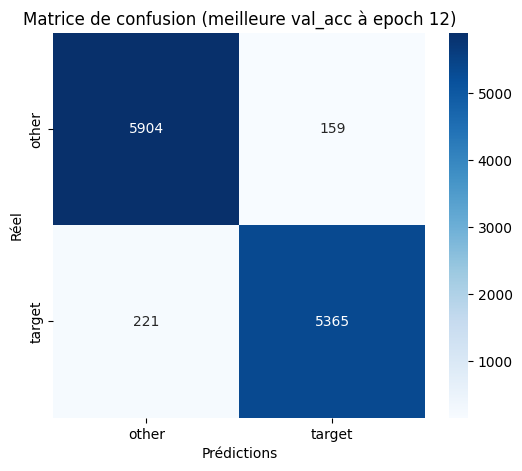

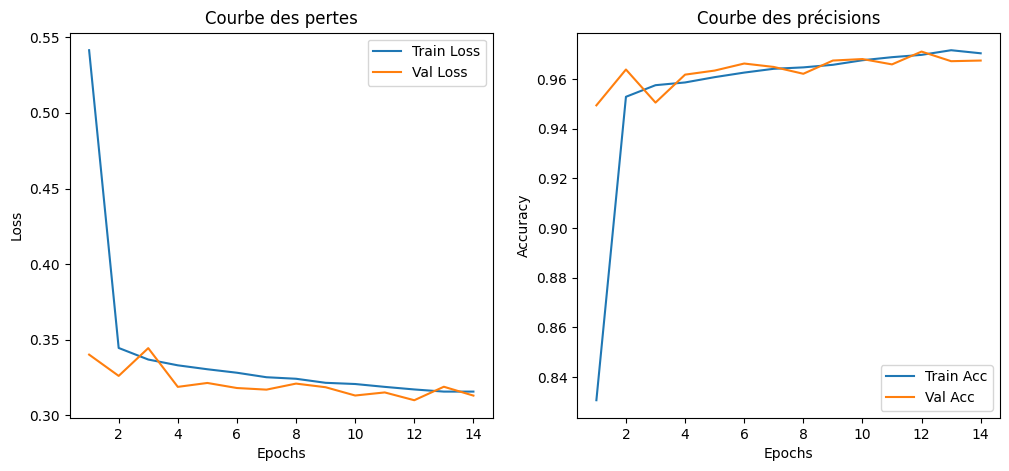

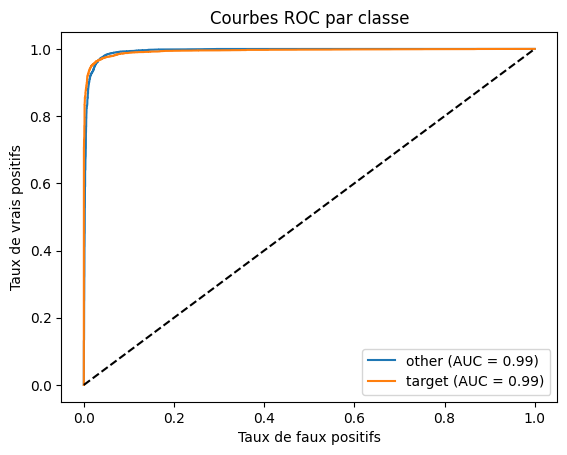

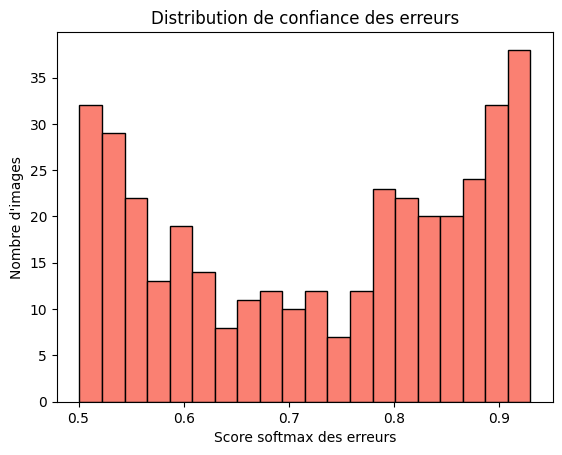

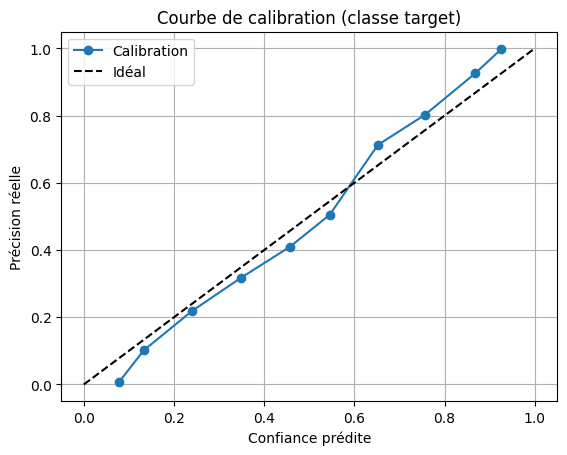

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# 🔧 Charger EfficientNet préentraîné
#model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# 🧠 Adapter la dernière couche pour 2 classes
#num_features = model.classifier[1].in_features
#model.classifier[1] = torch.torch.nn.Linear(num_features, 2)

#from torchvision.models import densenet121, DenseNet121_Weights
#model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
# 🧠 Adapter la dernière couche pour 2 classes
#num_features = model.classifier.in_features
#model.classifier = torch.nn.Linear(num_features, 2)
epochs = 14
from torchvision.models import resnet18, resnet34
# Charger le modèle pré-entraîné
model = resnet18(weights='IMAGENET1K_V1')  # ou weights=None si tu veux l'entraîner from scratch 'IMAGENET1K_V1'
# Adapter la dernière couche pour 2 classes
#model.fc = torch.nn.Linear(model.fc.in_features, 2) à decommenter si on veut enlever le dropout

##############early stop si la val loss n'evolue pas pendant patience epoch
early_stopper = EarlyStopping(patience=6, verbose=True, delta=0.001)


# Adapter la tête du modèle avec Dropout
in_features = model.fc.in_features

model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.15),  # ← Dropout ajouté ici
    torch.nn.Linear(256, 2)   # ← 2 classes
)

# Envoyer sur le bon device
model = model.to(device)

'''from sklearn.utils.class_weight import compute_class_weight
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)'''

#fonction de perte si les classes sont desequilibres
#criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(device))
#optimiseur adam
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=5e-4)
#optimiseur SGD
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.15)
#criterion = torch.nn.CrossEntropyLoss()

############## fais baisser le LR a chaque epoch selon une certaine fonction pour permettre a SGD de bien explorer au debut puis se stabiliser
from torch.optim.lr_scheduler import CosineAnnealingLR
#scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
from torch.optim.lr_scheduler import OneCycleLR

'''
scheduler = OneCycleLR(
    optimizer,
    max_lr=3e-3,                      # pic de lr
    epochs=epochs,                        # nombre d’epochs
    steps_per_epoch=len(train_loader),  # nombre de batches
    pct_start=0.3,                    # phase de montée (30%)
    anneal_strategy='cos',           # descente douce
    div_factor=3.0,                  # lr initial = max_lr / div_factor
    final_div_factor=1e4             # lr final = max_lr / final_div_factor
)
'''

scaler = torch.amp.GradScaler(device="cuda")
max_norm = 1.0


# Initialisation avant la boucle
best_val_loss = float("inf")
best_val_acc = -1
best_epoch = -1
best_acc_epoch = -1  # ← pour suivre l'époque de la meilleure accuracy
best_model_state = None  # ← stocke les poids ici
best_acc_model_state = None

# --- listes pour stocker les métriques ---
train_epoch_losses, train_epoch_accs = [], []
val_epoch_losses, val_epoch_accs = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # --- Entraînement ---
    model.train()
    train_loss_total = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc="Train", leave=False):
        images = images.to(device, non_blocking=True)

        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        scaler.step(optimizer)
        scaler.update()

        train_loss_total += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)

        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)


    train_epoch_loss = train_loss_total / train_total
    train_epoch_acc = train_correct / train_total
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_accs.append(train_epoch_acc)
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    misclassified = []
    predictions = []
    val_loss_total = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(tqdm(val_loader, desc="Val", leave=False)):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            val_loss_total += loss.item() * imgs.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            for j in range(len(imgs)):
                if preds[j] != labels[j]:
                    misclassified.append({
                        "batch_idx": i,
                        "img_idx": j,
                        "pred": preds[j].item(),
                        "true": labels[j].item()
                    })

    val_epoch_loss = val_loss_total / val_total
    val_epoch_acc = val_correct / val_total
    val_epoch_losses.append(val_epoch_loss)
    val_epoch_accs.append(val_epoch_acc)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

    # --- Sauvegarde du meilleur modèle ---
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_epoch = epoch + 1
        best_model_state = model.state_dict()  # ← ne sauvegarde pas encore

    # Meilleure accuracy
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_acc_epoch = epoch + 1
        best_acc_model_state = model.state_dict()
    # Après avoir calculé val_epoch_loss
    early_stopper(val_epoch_loss, model)
    if early_stopper.early_stop:
        print("Early stopping déclenché à l'epoch", epoch + 1)
        break
    '''scheduler.step()'''


# Charger le meilleur modèle en accuracy
model.load_state_dict(best_acc_model_state)
model.eval()

# Recalculer les prédictions sur le jeu de validation
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Val (best acc)", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice de confusion avec le meilleur modèle
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['other', 'target'],
            yticklabels=['other', 'target'])
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title(f'Matrice de confusion (meilleure val_acc à epoch {best_acc_epoch})')
plt.show()


# --- Tracé des courbes ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_epoch_losses)+1), train_epoch_losses, label="Train Loss")
plt.plot(range(1, len(val_epoch_losses)+1), val_epoch_losses, label="Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe des pertes")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_epoch_accs)+1), train_epoch_accs, label="Train Acc")
plt.plot(range(1, len(val_epoch_accs)+1), val_epoch_accs, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe des précisions")
plt.legend()

plt.show()

all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

for i, class_name in enumerate(['other', 'target']):
    fpr, tpr, _ = roc_curve(all_labels_np == i, all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC par classe')
plt.legend()
plt.show()


errors = (all_labels_np != np.array(all_preds))
error_scores = np.max(all_probs_np[errors], axis=1)

plt.hist(error_scores, bins=20, color='salmon', edgecolor='black')
plt.xlabel("Score softmax des erreurs")
plt.ylabel("Nombre d'images")
plt.title("Distribution de confiance des erreurs")
plt.show()


# Conversion en array
labels_np = np.array(all_labels)
preds_np = np.array(all_preds)
probs_np = np.array(all_probs)

# Score max par image
#max_scores = np.max(probs_np, axis=1)

labels_np = np.array(all_labels)
preds_np = np.array(all_preds)
max_scores = np.max(np.array(all_probs), axis=1)



from sklearn.calibration import calibration_curve

# Classe cible (ex: target = 1)
true_binary = (labels_np == 1).astype(int)
pred_scores = probs_np[:, 1]  # Score softmax pour classe "target"

# Courbe de calibration
prob_true, prob_pred = calibration_curve(true_binary, pred_scores, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], 'k--', label='Idéal')
plt.xlabel("Confiance prédite")
plt.ylabel("Précision réelle")
plt.title("Courbe de calibration (classe target)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#sauvegarde de resnet18
torch.save(model.state_dict(), 'resnet18_wind.pth')
# Sauvegarde finale

In [ ]:
print("best_acc_model_state is None:", best_acc_model_state is None)


best_acc_model_state is None: False


In [ ]:
from pathlib import Path
import torch

# 📁 Répertoire de sauvegarde
save_dir = Path(data_dir).parent / "Models"
save_dir.mkdir(parents=True, exist_ok=True)

# 💾 Sauvegarde du modèle avec la meilleure loss
loss_filename = f"best_model_loss_epoch{best_epoch}_valloss{best_val_loss:.4f}.pth"
torch.save(best_model_state, save_dir / loss_filename)
print(f"Modèle sauvegardé (meilleure loss) : {loss_filename}")

# 💾 Sauvegarde du modèle avec la meilleure accuracy
acc_filename = f"best_model_acc_epoch{best_acc_epoch}_valacc{best_val_acc:.4f}.pth"
torch.save(best_acc_model_state, save_dir / acc_filename)
print(f"Modèle sauvegardé (meilleure accuracy) : {acc_filename}")

Modèle sauvegardé (meilleure loss) : best_model_loss_epoch12_valloss0.3101.pth
Modèle sauvegardé (meilleure accuracy) : best_model_acc_epoch12_valacc0.9710.pth


# Code pour l'évaluation finale

## **Partie à modifier en suivant les consignes** Important de votre modèle final, entraîné
**Consignes:**
* Seule cette partie sera exécutée pour l'évaluation finale (tout ce qui est au dessus sera ignoré)
* Il vous est demandé de remettre votre architecture ici, en appelant la classe final_model (voir le code ci-dessous). Ne changez que la définition du final_model et sa fonction `forward`, **mais pas le nom de la classe**
* Votre modèle doit avoir été entrainé, et vous devez avoir sauvergardé la valeur des paramètres du modèle entrainé avec `torch.save` pour qu'il n'y ai plus qu'à charger le modèle.
* **Important** le nom du fichier qui charge les poids ne doit pas être changé: `final_model_trained_weights.pth`

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class final_model(torch.nn.Module):
    def __init__(self):
        super(final_model, self).__init__()


        self.backbone = models.resnet18(weights=None)

        # Reproduire EXACTEMENT la tête utilisée pendant l'entraînement
        in_features = self.backbone.fc.in_features

        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(256, 2)   # 2 classes
        )

    def forward(self, x):
        return self.backbone(x)



In [ ]:
model = final_model() # à changez éventuellement en fonction de votre modèle
model.load_state_dict(torch.load('final_model_trained_weights.pth', weights_only=True))

## **Ne pas modifier:** Exportation des résultats pour évaluation finale

In [ ]:
import os
import pandas as pda

# Définir la transformation pour les images de test
data_transforms['test'] = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger les images de test
prediction_dir = data_dir + "/evaluation_finale/"
test_dataset = datasets.ImageFolder(prediction_dir, transform=data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Mettre le modèle en mode évaluation
model.eval()

# Liste pour stocker les prédictions
predictions = []
img_names = []

# Faire des prédictions sur les images de test
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.item())

### LES LIGNES SUIVANTES SONT À NE PAS TOUCHER!
### Elles servent à creer un fichier que vous devez fournir dans le rendu.
### Ce fichier garde les predictions dans un format qui nous permet de verifier par rapport aux vraies étiquettes.

# Extraire les noms des fichiers d'images depuis test_dataset.samples
file_paths = [sample[0] for sample in test_dataset.samples]
img_names = [os.path.basename(path) for path in file_paths]  # Obtenir juste le nom du fichier image

# Créer un DataFrame avec les résultats
results_df = pda.DataFrame({'name': img_names, 'prediction': predictions})

# Sauvegarder le fichier dans le format souhaité : name;prediction
results_df.to_csv(data_dir + '/predictions.csv', index=False, sep=';')

In [ ]:
import numpy as np
true_target = np.arange(len(test_loader), dtype=float) < int(len(test_loader) / 2)
print('Accuracy:', np.sum(results_df['prediction'] == true_target) / len(test_loader) * 100, '%')